<a href="https://colab.research.google.com/github/matthewberry/uiuc_com_dsp/blob/master/DSP_personalized_medicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tuning Random Forests in Virtual Twins

Personalized medicine draws a lot of attention in medical research. The goal of personalized medicine is to make a tailored decision for each patient, such that his/her clinical outcome can be optimized.

Let’s consider data modified from the [SIDES method](http://biopharmnet.com/subgroup-analysis-software/). In this dataset, 470 patients and 13 variables are observed. The variables are listed below.

*   `Health`: Health outcome (larger the better)
*   `THERAPY`: 1 for active treatment, 0 for the control treatment
*   `TIMFIRST`: Time from first sepsis-organ fail to start drug
*   `AGE`: Patient age in years
*   `BLLPLAT`: Baseline local platelets
*   `blSOFA`: Sum of baseline sofa score (cardiovascular, hematology, hepatorenal, and respiration scores)
*   `BLLCREAT`: Base creatinine
*   `ORGANNUM`: Number of baseline organ failures
*   `PRAPACHE`: Pre-infusion apache-ii score
*   `BLGCS`: Base GLASGOW coma scale score
*   `BLIL6`: Baseline serum IL-6 concentration
*   `BLADL`: Baseline activity of daily living score
*   `BLLBILI`: Baseline local bilirubin
*   `BEST`: The true best treatment suggested by doctors. **You should not use this variable when fitting models!**

For each patient, sepsis was observed during their hospital stay. Hence, one of the two treatments (indicated by variable `THERAPY`) must be chosen to prevent further adverse events. After the treatment, the patient's health outcome (`Health`) was measured, with a larger value being the better outcome.

Because treatments were assigned randomly, we are not able to suggest better treatment for a new patient. A strategy called [Virtual Twins](https://onlinelibrary.wiley.com/doi/abs/10.1002/sim.4322) was proposed by Foster et al. (2011) to tackle this problem. We consider a simpler version of the method. We fit two random forests to model the outcome `Health`: one model uses all patients who received treatment 1, and another model for all patients who received treatment 0. Denote these two models as $\widehat f_1(x)$ and $\widehat f_0(x)$, respectively. When a new patient arrives, we use both models to predict the outcomes and see which model gives a better health status. We will suggest the treatment label associated with the model that gives a larger prediction value. In other words, for a new $x^{*}$, we compare $\widehat f_1(x^{*})$ and $\widehat f_0(x^{*})$ and suggest the better label. The goal for this question is to select tuning parameters for random forest such that it will suggest the best treatment for a patient. Perform the following:

Randomly split the data into 75% for training and 25% for testing.
For the training data, fit the virtual twins model and then use the testing data to suggest the best treatment.
You should not use the variable `BEST` when fitting the models
Pick three different mtry values and three different nodesize, leave all other tuning parameters as default.
After predicting the best treatment in the testing data, compare it to the truth `BEST`
Repeat this entire process 100 times and average the prediction errors
Summarize your results, including the model performance and the effect of tuning parameters. Intuitively demonstrate them.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



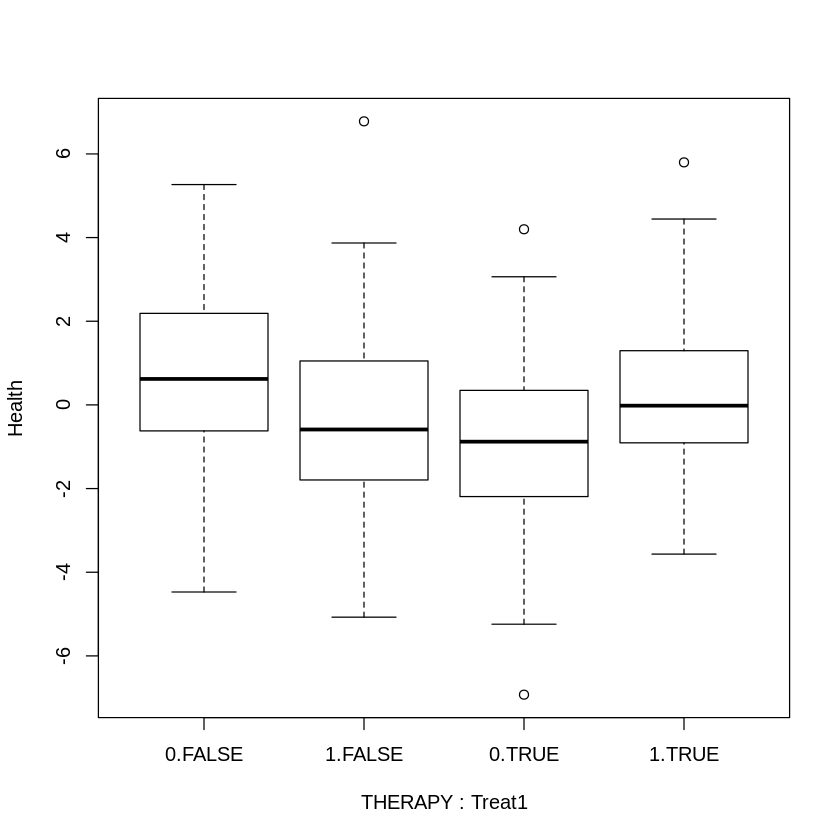

In [19]:
# This is how the data was generated
# you do not need this
install.packages("aVirtualTwins", repos = "http://cran.rstudio.com/")
library(aVirtualTwins)

# load data sepsis
data(sepsis)
set.seed(1)
Treat1 = (sepsis$PRAPACHE < 26 & sepsis$AGE < 50) | (sepsis$PRAPACHE >= 26 & sepsis$BLGCS < 12)
n = nrow(sepsis)
THERAPY = rbinom(n, 1, 0.5)

Health = rnorm(n, 0.5, 2)*Treat1*(THERAPY == 1) + rnorm(n, -0.5, 2)*Treat1*(THERAPY == 0) + 
        rnorm(n, -0.5, 2)*(!Treat1)*(THERAPY == 1) + rnorm(n, 0.5, 2)*(!Treat1)*(THERAPY == 0)
  
boxplot(Health~ THERAPY + Treat1)
  
Sepsis = sepsis
colnames(Sepsis)[1] = "Health"
  
Sepsis$Health = Health
Sepsis$THERAPY = THERAPY
Sepsis$BEST = Treat1 + 0
write.csv(Sepsis, file="data/Sepsis.csv")

In [20]:
library(tidyverse)
Sepsis <- read_csv("data/Sepsis.csv")
head(Sepsis)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  Health = col_double(),
  THERAPY = col_double(),
  PRAPACHE = col_double(),
  AGE = col_double(),
  BLGCS = col_double(),
  ORGANNUM = col_double(),
  BLIL6 = col_double(),
  BLLPLAT = col_double(),
  BLLBILI = col_double(),
  BLLCREAT = col_double(),
  TIMFIRST = col_double(),
  BLADL = col_double(),
  blSOFA = col_double(),
  BEST = col_double()
)



X1,Health,THERAPY,PRAPACHE,AGE,BLGCS,ORGANNUM,BLIL6,BLLPLAT,BLLBILI,BLLCREAT,TIMFIRST,BLADL,blSOFA,BEST
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-3.188260,0,19,42.921,15,1,301.80,191.0000,2.913416,1.000000,17.17,0,5.00,1
2,-3.546312,0,48,68.818,11,2,118.90,264.1565,0.400000,1.100000,17.17,5,10.00,1
3,1.188689,1,20,68.818,15,2,92.80,123.0000,5.116471,1.000000,10.00,1,7.50,0
4,2.693554,1,19,33.174,14,2,1232.00,244.0000,3.142092,1.200000,17.17,0,6.25,1
5,3.007590,0,48,46.532,3,4,2568.00,45.0000,4.052668,3.000000,10.00,0,12.00,1
6,3.870876,1,21,56.098,14,1,162.65,137.0000,0.500000,4.662556,10.00,0,8.75,0


In [21]:
library(randomForest)

nsim = 100
N = nrow(Sepsis)

allTune = expand.grid("nodesize" = c(1, 5, 10),
            "mtry" = c(1, 4, 12))
Error = matrix(NA, nrow(allTune), nsim)

set.seed(1)

for (k in 1:nsim)
{
  intrain <- sample(1:N, N/2)
  
  train = Sepsis[intrain, ]
  test = Sepsis[-intrain, ]
  
  for (j in 1:nrow(allTune))
  {
    model0 <- randomForest(Health ~ . - BEST, data = train[train$THERAPY == 0, ], 
                           mtry = allTune$mtry[j], nodesize = allTune$nodesize[j])
    model1 <- randomForest(Health ~ . - BEST, data = train[train$THERAPY == 1, ], 
                           mtry = allTune$mtry[j], nodesize = allTune$nodesize[j])
    
    test0 = predict(model0, test)
    test1 = predict(model1, test)
    
    suggest = (test1 > test0)
    Error[j, k] = mean(suggest != test$BEST)
  }
}

cbind(allTune, "Errors" = rowMeans(Error))

nodesize,mtry,Errors
<dbl>,<dbl>,<dbl>
1,1,0.3189787
5,1,0.3151064
10,1,0.3138723
1,4,0.2883830
5,4,0.2828511
10,4,0.2787660
1,12,0.2770638
5,12,0.2740851
10,12,0.2682979


It seems larger nodesize and larger mtry is better in this data
this is likely because the underlying truth is a simple model (so we don't need small node size to reduce the bias)
and it is probably sparse (comparing all mtry variable will give us better chance to find the true one)

# Second Step in Virtual Twins
The second step in a virtual twins model is to use a single tree model (CART) to describe the choice of the best treatment. Perform the following: * Based on your optimal tuning parameter, fit the Virtual Twins model described in Question 1. Again, you should not use the BEST variable. * For each subject, obtain the predicted best treatment of the training data itself * Treating the label of best treatment as the outcome, and fit a single tree model to predict it. Be careful which variables should be removed from this model fitting. * Consider tuning the tree model using the cost-complexity tuning.
![alt text](https://)

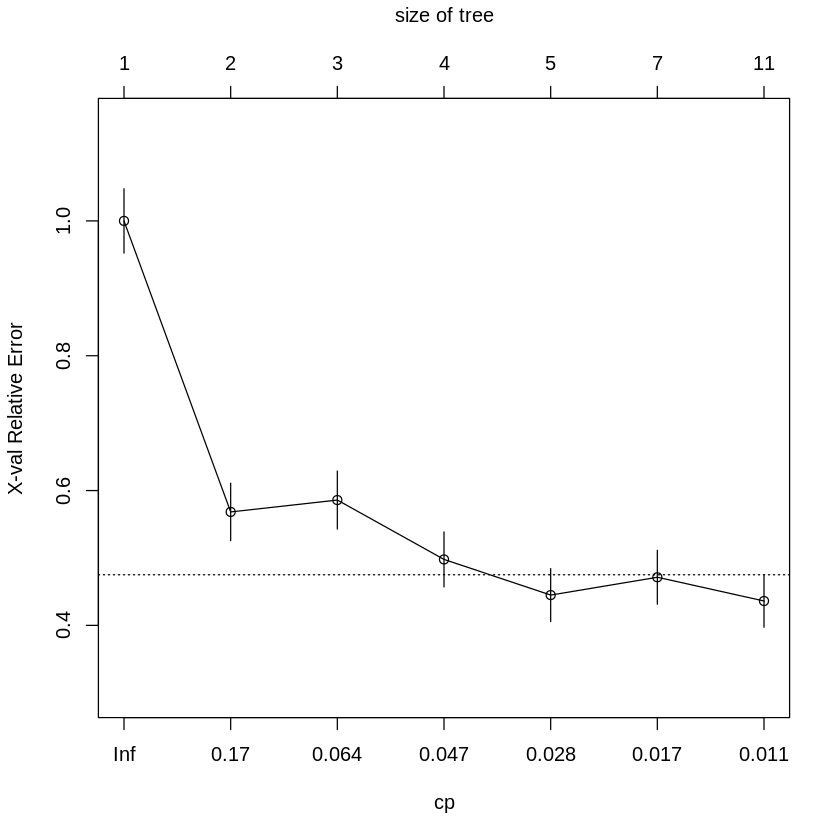

In [12]:
library(rpart)

model0 <- randomForest(Health ~ . - BEST, data =  Sepsis[Sepsis$THERAPY == 0, ], mtry = 12, nodesize = 10)
model1 <- randomForest(Health ~ . - BEST, data =  Sepsis[Sepsis$THERAPY == 1, ], mtry = 12, nodesize = 10)

pred0 = predict(model0, Sepsis)
pred1 = predict(model1, Sepsis)

Sepsis$FitBest = (pred1 > pred0)

rpart.fit = rpart(as.factor(FitBest) ~ . - BEST - Health - THERAPY, data = Sepsis)
plotcp(rpart.fit)

In [13]:
rpart.fit$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.43171806,0,1.0000000,1.0000000,0.04772449
2,0.06607930,1,0.5682819,0.5682819,0.04261841
3,0.06167401,2,0.5022026,0.5859031,0.04301956
4,0.03524229,3,0.4405286,0.4977974,0.04081300
5,0.02202643,4,0.4052863,0.4449339,0.03922826
6,0.01321586,6,0.3612335,0.4713656,0.04004704
7,0.01000000,10,0.3083700,0.4361233,0.03894303


In [14]:
prune(rpart.fit, cp = 0.018)

n= 470 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 470 227 FALSE (0.5170213 0.4829787)  
   2) AGE>=51.7395 310  98 FALSE (0.6838710 0.3161290)  
     4) PRAPACHE< 25.5 175  23 FALSE (0.8685714 0.1314286) *
     5) PRAPACHE>=25.5 135  60 TRUE (0.4444444 0.5555556)  
      10) PRAPACHE< 35 94  40 FALSE (0.5744681 0.4255319)  
        20) X1< 413.5 86  32 FALSE (0.6279070 0.3720930)  
          40) BLLBILI>=1.75 28   4 FALSE (0.8571429 0.1428571) *
          41) BLLBILI< 1.75 58  28 FALSE (0.5172414 0.4827586)  
            82) TIMFIRST< 23.115 24   6 FALSE (0.7500000 0.2500000) *
            83) TIMFIRST>=23.115 34  12 TRUE (0.3529412 0.6470588) *
        21) X1>=413.5 8   0 TRUE (0.0000000 1.0000000) *
      11) PRAPACHE>=35 41   6 TRUE (0.1463415 0.8536585) *
   3) AGE< 51.7395 160  31 TRUE (0.1937500 0.8062500) *

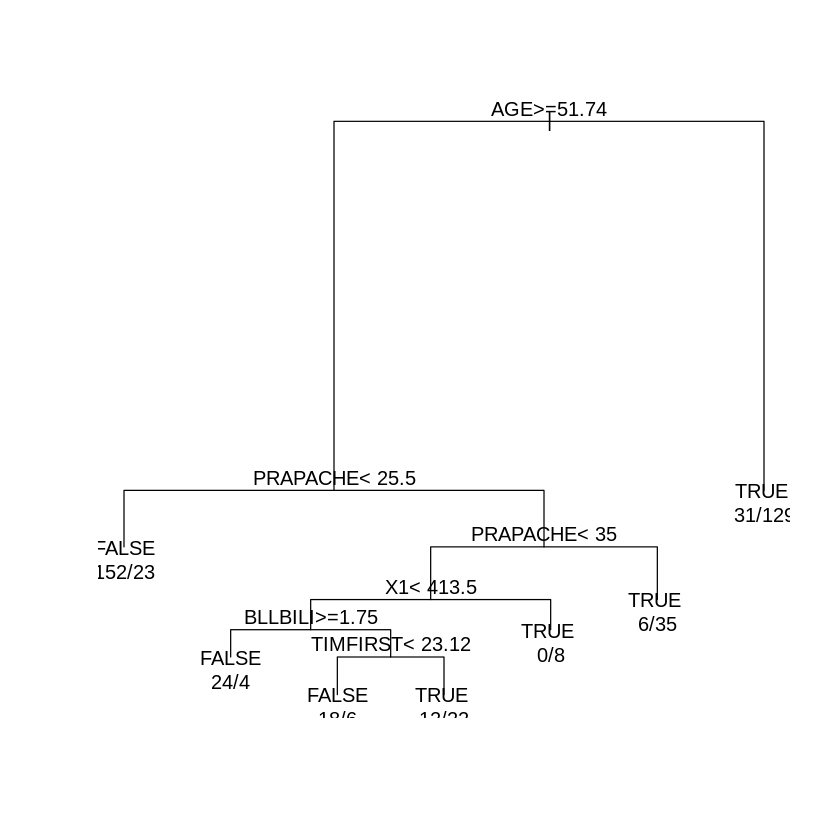

In [15]:
rpart.fit = rpart(as.factor(FitBest) ~ . - BEST - Health - THERAPY, data = Sepsis, cp = 0.018)

plot(rpart.fit)
text(rpart.fit, use.n = TRUE)